In [25]:
import os 
import pandas as pd
pd.set_option('display.max_columns', None)
import subprocess
import glob
import pybedtools as pbt 
pbt.set_bedtools_path('/mnt/BioApps/bedtools/bin/')
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt 

os.chdir('/mnt/BioHome/jreyna/jreyna-temp/projects/dchallenge/')

genome_sizes = 'results/refs/hg19/hg19.chrom.sizes'

# make the directory to save our data
outdir = 'results/main/pieqtls/sgl_intersect/'
os.makedirs(outdir, exist_ok=True)

In [86]:
from chromolooper import sgls

In [27]:
gs_fn = 'results/refs/hg19/hg19.chrom.nochr.sizes'
gencode_fn = 'results/refs/gencode/v30/gencode.v30.annotation.bed'
gencode = pd.read_table(gencode_fn, header=None)
gencode = gencode.drop_duplicates(5)
gencode_dict = {k:v for k,v in gencode[[5,6]].values.tolist()} 
gencode_dict.update({v:k for k,v in gencode[[5,6]].values.tolist()})

## Load Significant GWAS

In [28]:
major_gwas = ['T1D_32005708', 'T1D_34594039_GCST90018925', 'T1D_34012112_Gaulton']

In [29]:
data = []
gwas = 'results/main/coloc/Data/T1D_GWAS/*/GRCh37/GWAS_input_colocalization_pval_lt_5eMinus8.txt'
for fn in glob.glob(gwas):
    path_info = fn.split('/')
    df = pd.read_table(fn)
    
    if path_info[5] not in major_gwas:
        continue
        
    df['gwas_source'] = path_info[5]
    data.append(df)    
gwas_df = pd.concat(data)
gwas_df['sid'] = gwas_df['CHR'].str.replace('chr', '') + ':' + gwas_df['POS'].astype(str)

# loading finemap data into bedtools
gwas_bed = gwas_df.iloc[:, [0,1,1]]
gwas_bed.columns = ['chrom', 'start', 'end']
gwas_bed['start'] = gwas_bed['start'] - 1
gwas_pbt = pbt.BedTool.from_dataframe(gwas_bed)

/tmp/ipykernel_57681/915015123.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_bed['start'] = gwas_bed['start'] - 1


In [30]:
individual_gwas_studies = gwas_df.groupby('gwas_source').sid.nunique()
individual_gwas_studies = individual_gwas_studies.to_frame()
individual_gwas_studies.columns = ['Number of Sig. GWAS']

In [31]:
individual_gwas_studies

,Number of Sig. GWAS
gwas_source,
T1D_32005708,21097
T1D_34012112_Gaulton,45798
T1D_34594039_GCST90018925,20419


## Load pieQTLs

In [32]:
pieqtls = glob.glob('results/main/pieqtls/2021_chandra_et_al/*/proximal.pieqtls.tsv')

pieqtl_data = []
for pieqtl in pieqtls:
    print(pieqtl)
    
    cline = pieqtl.split('/')[-2]
    df = pd.read_table(pieqtl)    
    df['cline'] = cline
    pieqtl_data.append(df) 
    
pieqtl_df = pd.concat(pieqtl_data)
pieqtl_df['Chromosome'] = pieqtl_df['Chromosome']
pieqtl_df.loc[:, 'sid'] = pieqtl_df['Chromosome'].str.replace('chr', '') + ':' + \
                          pieqtl_df['pieQTL.Position'].astype(str)

results/main/pieqtls/2021_chandra_et_al/CD8_T-cell_naive/proximal.pieqtls.tsv
results/main/pieqtls/2021_chandra_et_al/CD4_T-cell_naive/proximal.pieqtls.tsv
results/main/pieqtls/2021_chandra_et_al/NK-cell_naive/proximal.pieqtls.tsv
results/main/pieqtls/2021_chandra_et_al/monocyte_naive/proximal.pieqtls.tsv
results/main/pieqtls/2021_chandra_et_al/B-cell_naive/proximal.pieqtls.tsv


In [33]:
individual_cells = pieqtl_df.groupby('cline').Target_geneID.nunique()
individual_cells = individual_cells.to_frame()
individual_cells.columns = ['Number of pieQTL Genes']
individual_cells

,Number of pieQTL Genes
cline,
B-cell_naive,1233
CD4_T-cell_naive,1168
CD8_T-cell_naive,1081
NK-cell_naive,872
monocyte_naive,1065


In [34]:
individual_cells = pieqtl_df.groupby('cline').sid.nunique()
individual_cells = individual_cells.to_frame()
individual_cells.columns = ['Number of pieQTL SNPs']
individual_cells

,Number of pieQTL SNPs
cline,
B-cell_naive,8110
CD4_T-cell_naive,6800
CD8_T-cell_naive,5539
NK-cell_naive,5332
monocyte_naive,6006


In [35]:
pieqtl_bed = pieqtl_df.iloc[:, [1,2,2,-1]]
pieqtl_bed.columns = ['chrom', 'start', 'end', 'cline']
pieqtl_bed.loc[:, 'start'] = pieqtl_bed['start'] - 1
pieqtl_pbt = pbt.BedTool.from_dataframe(pieqtl_bed)

/tmp/ipykernel_57681/2754423286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pieqtl_bed.loc[:, 'start'] = pieqtl_bed['start'] - 1


In [36]:
pieqtl_bed.shape

(35898, 4)

## Intersect pieQTLs and Sig GWAS

In [37]:
major_cols = ['ge_source',
             'rsid',
             'chrom',
             'pos',
             'geneid',
             'genename',
             'allele1',
             'allele2',
             'maf',
             'beta_x',
             'se',
             'z',
             'prob',
             'log10bf',
             'mean',
             'sd',
             'mean_incl',
             'sd_incl',
             'pval',
             'gwas_source',
             'pieQTL.ID',
             'Chromosome',
             'pieQTL.Position',
             'Target_geneName',
             'TSS',
             'pvalue',
             'FDR (DICE)',
             'beta_y',
             'ref',
             'alt',
             'Mean.TPM.Homozygous.Reference',
             'Mean.TPM.Heterozygous',
             'Mean.TPM.Homozygous.Alternative',
             'Interaction_type',
             'GWAS.Trait',
             'cline',
             'regionID',
             'GWASLoci',
             'index']


### Intersection

In [38]:
intersect_df = pd.merge(gwas_df, pieqtl_df,
                        left_on=['CHR', 'POS'],
                        right_on=['Chromosome', 'pieQTL.Position'],
                        how='inner')

In [39]:
indiv_cell_intersect = intersect_df.groupby('cline').Target_geneID.nunique().to_frame()
indiv_cell_intersect.columns = ['Number of Unique Genes from pieQTL & Sig.GWAS Intersection']
indiv_cell_intersect

,Number of Unique Genes from pieQTL & Sig.GWAS Intersection
cline,
B-cell_naive,39
CD4_T-cell_naive,33
CD8_T-cell_naive,35
NK-cell_naive,45
monocyte_naive,25


In [40]:
indiv_cell_intersect = intersect_df.groupby('cline').sid_x.nunique().to_frame()
indiv_cell_intersect.columns = ['Number of Unique SNPs from pieQTL & Sig.GWAS Intersection']
indiv_cell_intersect

,Number of Unique SNPs from pieQTL & Sig.GWAS Intersection
cline,
B-cell_naive,348
CD4_T-cell_naive,322
CD8_T-cell_naive,269
NK-cell_naive,319
monocyte_naive,116


In [41]:
indiv_cell_intersect = intersect_df.groupby(['cline', 'gwas_source']).Target_geneID.nunique().to_frame()
indiv_cell_intersect.columns = ['Number of Unique Genes from pieQTL & Sig.GWAS Intersection']
indiv_cell_intersect

Number of Unique Genes from pieQTL & Sig.GWAS Intersection
cline            gwas_source                                                                          
B-cell_naive     T1D_32005708                                                              28         
                 T1D_34012112_Gaulton                                                      34         
                 T1D_34594039_GCST90018925                                                 21         
CD4_T-cell_naive T1D_32005708                                                              15         
                 T1D_34012112_Gaulton                                                      29         
                 T1D_34594039_GCST90018925                                                 14         
CD8_T-cell_naive T1D_32005708                                                              18         
                 T1D_34012112_Gaulton                                                      30         
                 T1D_34594039_GCST90018925                                                 15         
NK-cell_naive    T1D_32005708                                                              34         
                 T1D_34012112_Gaulton                                                      36         
                 T1D_34594039_GCST90018925                                                 17         
monocyte_naive   T1D_32005708                                                              14         
                 T1D_34012112_Gaulton                                                      22         
                 T1D_34594039_GCST90018925                                                  8

In [42]:
indiv_cell_intersect = intersect_df.groupby(['cline', 'gwas_source']).sid_x.nunique().to_frame()
indiv_cell_intersect.columns = ['Number of Unique SNPs from pieQTL & Sig.GWAS Intersection']
indiv_cell_intersect

Number of Unique SNPs from pieQTL & Sig.GWAS Intersection
cline            gwas_source                                                                         
B-cell_naive     T1D_32005708                                                             186        
                 T1D_34012112_Gaulton                                                     241        
                 T1D_34594039_GCST90018925                                                116        
CD4_T-cell_naive T1D_32005708                                                             142        
                 T1D_34012112_Gaulton                                                     198        
                 T1D_34594039_GCST90018925                                                 53        
CD8_T-cell_naive T1D_32005708                                                             136        
                 T1D_34012112_Gaulton                                                     155        
                 T1D_34594039_GCST90018925                                                 73        
NK-cell_naive    T1D_32005708                                                             171        
                 T1D_34012112_Gaulton                                                     175        
                 T1D_34594039_GCST90018925                                                 77        
monocyte_naive   T1D_32005708                                                              82        
                 T1D_34012112_Gaulton                                                      76        
                 T1D_34594039_GCST90018925                                                 33

In [43]:
def get_genename(x):
    if x in gencode_dict:
        return(gencode_dict[x])
    else:
        return(x)

In [44]:
intersect_df.loc[:, 'geneid'] = intersect_df['Target_geneID'].str.replace('\.[0-9]*', '', regex=True)
intersect_df.loc[:, 'genename'] = intersect_df.loc[:, 'geneid'].apply(get_genename)

In [45]:
intersect_df.loc[:, 'geneid'].nunique()

91

In [46]:
for x in intersect_df.genename.unique():
    print(x)

HCG27
ZSCAN9
ZSCAN26
TRIM27
ENSG00000261353
BTN2A3P
TAP2
RPL32P1
WDR46
AL645929.1
BTNL2
TSBP1
ZNRD1ASP
ZKSCAN4
BTN2A1
BTN2A2
AL645933.2
LY6G5B
BTN3A1
TCF19
SUOX
MICA
CCHCR1
LY6G5C
IFITM4P
BTN3A2
AL662844.3
AL662844.4
HMGN4
LST1
PTPN22
TMEM116
AL645939.1
ZFP57
SKIV2L
DHX16
FLOT1
PPP1R18
ZNF165
RF00019
TRIM26
HCG18
MICB
PRRC2A
BAG6
CSNK2B
C6orf47
AL671277.2
HCG24
ENSG00000228962
ZDHHC20P1
GNL1
ZNF192P1
ZSCAN23
HECTD4
HCG4B
RNF39
PFDN6
BACH2
C1orf216
FHL3
SF3A3
RGS1
NPM1P33
KRT18P39
CD28
SLC22A5
VARS2
MRPS18B
TUBB
C6orf136
NCR3
C6orf48
AIF1
MSH5
PPT2
AP003774.4
M6PR
LINC02390
ATXN2
MAPKAPK5
CTSH
AC009121.1
RMI2
DND1P1
KANSL1-AS1
AP005482.1
ZGLP1
PRKD2
TMPRSS3


## Summarize

In [47]:
# find the unique SNPs
uniq_snps_by_cells = intersect_df.groupby('cline').sid_x.nunique()
uniq_snps_by_cells = uniq_snps_by_cells.to_frame()

# find the unique genes 
uniq_genes_by_cells = intersect_df.groupby('cline').geneid.nunique()
uniq_genes_by_cells = uniq_genes_by_cells.to_frame()

# merge snps and genes
uniq_counts_by_cells = pd.merge(uniq_snps_by_cells, uniq_genes_by_cells, left_index=True, right_index=True)
uniq_counts_by_cells.columns = ['Number of Unique SNPs', 'Number of Unique Genes']
uniq_counts_by_cells.index.name = 'Cell Line'

In [48]:
# save the file
excel_analysis = os.path.join(outdir, 'Unique_Counts_By_Cell_Line.xlsx')
uniq_counts_by_cells.to_excel(excel_analysis, sheet_name='pieqtls')

In [49]:
uniq_genes_by_cells

,geneid
cline,
B-cell_naive,39
CD4_T-cell_naive,33
CD8_T-cell_naive,35
NK-cell_naive,45
monocyte_naive,25


In [50]:
excel_analysis

'results/main/pieqtls/sgl_intersect/Unique_Counts_By_Cell_Line.xlsx'

#### Write the gene list as well

In [51]:
gh_list = sorted(intersect_df.geneid.unique().tolist())
gh_fn = os.path.join(outdir, 'gene_list.txt')
with open(gh_fn, 'w') as fw:
    for x in gh_list:
        fw.write('{}\n'.format(x))

In [52]:
gh_list = sorted(intersect_df.geneid.unique().tolist())

In [53]:
len(gh_list)

91

In [54]:
intersect_df[['cline', 'geneid']]

,cline,geneid
0,monocyte_naive,ENSG00000206344
1,NK-cell_naive,ENSG00000137185
2,B-cell_naive,ENSG00000197062
3,monocyte_naive,ENSG00000204713
4,CD4_T-cell_naive,ENSG00000261353
...,...,...
2137,CD4_T-cell_naive,ENSG00000160183
2138,CD8_T-cell_naive,ENSG00000160183
2139,CD4_T-cell_naive,ENSG00000160183
2140,CD8_T-cell_naive,ENSG00000160183


#### Get the unique genes per cell type 

In [55]:
genes_by_cell = intersect_df[['cline', 'geneid']].drop_duplicates()
genes_by_cell.sort_values(['cline', 'geneid'], inplace=True)
genes_by_cell['source'] = 'pieqtls_with_sig_gwas'
genes_by_cell.columns = ['cline', 'geneid', 'source']
fn = os.path.join(outdir, 'genes_by_cell.xlsx')
genes_by_cell.to_excel(fn, index=False)

#### Make a figure of uniq SNPs and Genes per cell

In [56]:
color_fn = 'results/refs/dice_colors/colors.revised.t1d-project.tsv'
colors = pd.read_table(color_fn)
cline_pubnames = {'CD4_T-cell_naive': 'CD4 T-cells', 'CD8_T-cell_naive': 'CD8 T-cells',
                  'monocyte_naive': 'Monocytes', 'B-cell_naive': 'B-cells', 'NK-cell_naive': 'NK cells'}
colors_dict = {sr.studyname: sr.hex for i, sr in colors.iterrows()}

In [57]:
uniq_counts_by_cells['pubnames'] = uniq_counts_by_cells.index.map(cline_pubnames)

In [58]:
uniq_counts_by_cells.sort_values('pubnames', inplace=True)

In [59]:
uniq_counts_by_cells

,Number of Unique SNPs,Number of Unique Genes,pubnames
Cell Line,,,
B-cell_naive,348,39,B-cells
CD4_T-cell_naive,322,33,CD4 T-cells
CD8_T-cell_naive,269,35,CD8 T-cells
monocyte_naive,116,25,Monocytes
NK-cell_naive,319,45,NK cells


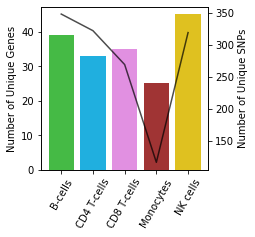

In [60]:
fig, ax = plt.subplots(figsize=(3,3))


sns.barplot(x='pubnames', y='Number of Unique Genes', palette=colors_dict, data=uniq_counts_by_cells, dodge=False)

ax.set_xlabel('')
ax.set_xticklabels(uniq_counts_by_cells['pubnames'], rotation = 60)

ax2 = ax.twinx()
sns.lineplot(x='pubnames', y='Number of Unique SNPs', data=uniq_counts_by_cells, color='#000000B3', ax=ax2)

sgl_summary_fn = os.path.join(outdir, 'sgls_pieqtls_with_sig_gwas_summary.svg')
fig.savefig(sgl_summary_fn)

## Save a unique list of SNPs within an SGL

In [61]:
gwas_grps = intersect_df.groupby('gwas_source')
for gwas_source, gwas_df in gwas_grps:
    
    uniq_sids = gwas_df.sid_x.drop_duplicates().sort_values()
    uniq_sids = uniq_sids.str.replace(':', '-')
    
    fn = os.path.join(outdir, 'pieqtls_sgls.{}.tsv'.format(gwas_source))
    uniq_sids.to_csv(fn, header=False, index=False)

In [62]:
intersect_df.sid_x.nunique()

868

## Check Out SNPs

In [63]:
intersect_df.head(4)

,CHR,POS,BETA,SE,P,N,gwas_source,sid_x,pieQTL.ID,Chromosome,pieQTL.Position,Target_geneID,Target_geneName,TSS,pvalue,FDR (DICE),beta,ref,alt,Mean.TPM.Homozygous.Reference,Mean.TPM.Heterozygous,Mean.TPM.Homozygous.Alternative,Interaction_type,GWAS.Trait,cline,sid_y,geneid,genename
0,chr6,31323409,0.2938,0.0381,1.286000e-14,24250.0,T1D_32005708,6:31323409,rs2523605,chr6,31323409,ENSG00000206344.6,HCG27,31165537,0.000021,0.008290,0.84,T,C,0.97,2.70,3.83,Direct_pieQTL,,monocyte_naive,6:31323409,ENSG00000206344,HCG27
1,chr6,28324397,0.1599,0.0238,1.877000e-11,24250.0,T1D_32005708,6:28324397,rs213236,chr6,28324397,ENSG00000137185.7,ZSCAN9,28192664,0.000021,0.011826,-0.68,T,C,50.52,45.47,41.05,Indirect_pieQTL,,NK-cell_naive,6:28324397,ENSG00000137185,ZSCAN9
2,chr6,28324397,0.1599,0.0238,1.877000e-11,24250.0,T1D_32005708,6:28324397,rs213236,chr6,28324397,ENSG00000197062.7,RP5-874C20.3,28234788,0.000056,0.017461,-0.64,T,C,22.50,20.95,18.54,Indirect_pieQTL,,B-cell_naive,6:28324397,ENSG00000197062,ZSCAN26
3,chr6,28902133,0.1567,0.0259,1.514000e-09,24250.0,T1D_32005708,6:28902133,rs1004062,chr6,28902133,ENSG00000204713.6,TRIM27,28891766,0.000026,0.009739,0.69,G,T,8.34,10.23,11.44,Direct_pieQTL,Body height,monocyte_naive,6:28902133,ENSG00000204713,TRIM27


In [64]:
intersect_df.loc[intersect_df.genename == 'RPS62']

,CHR,POS,BETA,SE,P,N,gwas_source,sid_x,pieQTL.ID,Chromosome,pieQTL.Position,Target_geneID,Target_geneName,TSS,pvalue,FDR (DICE),beta,ref,alt,Mean.TPM.Homozygous.Reference,Mean.TPM.Heterozygous,Mean.TPM.Homozygous.Alternative,Interaction_type,GWAS.Trait,cline,sid_y,geneid,genename


In [65]:
intersect_df.loc[intersect_df.geneid == 'ENSG00000170485']

,CHR,POS,BETA,SE,P,N,gwas_source,sid_x,pieQTL.ID,Chromosome,pieQTL.Position,Target_geneID,Target_geneName,TSS,pvalue,FDR (DICE),beta,ref,alt,Mean.TPM.Homozygous.Reference,Mean.TPM.Heterozygous,Mean.TPM.Homozygous.Alternative,Interaction_type,GWAS.Trait,cline,sid_y,geneid,genename


In [66]:
high = ['SF3A3',
 'PTPN22',
 'RGS1',
 'CTLA4',
 'SLC22A5',
 'BTN3A2',
 'BTN2A2',
 'BTN3A1',
 'BTN2A1',
 'ZKSCAN4',
 'TRIM27',
 'ZFP57',
 'TRIM26',
 'MRPS18B',
 'FLOT1',
 'VARS2',
 'MICA',
 'NCR3',
 'BAG6',
 'TSBP1',
 'BTNL2',
 'TAP2',
 'WDR46',
 'BACH2',
 'IL2RA',
 'RBM17',
 'M6PR',
 'SUOX',
 'RPS26',
 'CUX2',
 'ATXN2',
 'NAA25',
 'CTSH',
 'RMI2',
 'ZPBP2',
 'GSDMB',
 'ORMDL3',
 'VASP',
 'PRKD2',
 'IL2RB',
 'RAC2',
 'MFNG']

In [67]:
high_df = intersect_df.loc[(intersect_df.genename.isin(high)) & (intersect_df.Interaction_type == 'Direct_pieQTL')]

In [68]:
for rs in sorted(set(high_df['pieQTL.ID'].tolist())):
    print(rs)

rs1004062
rs10801129
rs10806423
rs10842537
rs10842660
rs10842662
rs10858022
rs12149160
rs1217418
rs1217419
rs1217420
rs12369009
rs12592898
rs13214027
rs1323298
rs1345229
rs1610625
rs1805722
rs1805723
rs184093
rs1977
rs1978
rs1979
rs2071790
rs2072806
rs2080116
rs2080117
rs209122
rs209137
rs209138
rs209142
rs2394164
rs2516708
rs2516714
rs2516715
rs2518030
rs261947
rs28551159
rs3047288
rs3130843
rs3130889
rs3131059
rs3135303
rs3135315
rs34260811
rs35260072
rs369136
rs371337998
rs3742003
rs3757138
rs3803170
rs413158
rs45553631
rs4634439
rs4713242
rs4713244
rs58521088
rs60254670
rs62408211
rs6454805
rs6661817
rs66823108
rs68072215
rs6899623
rs6920256
rs7189239
rs72841536
rs7309325
rs769178
rs79166578
rs905671
rs918738
rs9348716
rs9366654
rs9366655
rs9379871
rs9393715
rs943689
rs969577
ss1388091585
ss1388091598


In [69]:
intersect_df

,CHR,POS,BETA,SE,P,N,gwas_source,sid_x,pieQTL.ID,Chromosome,pieQTL.Position,Target_geneID,Target_geneName,TSS,pvalue,FDR (DICE),beta,ref,alt,Mean.TPM.Homozygous.Reference,Mean.TPM.Heterozygous,Mean.TPM.Homozygous.Alternative,Interaction_type,GWAS.Trait,cline,sid_y,geneid,genename
0,chr6,31323409,0.293800,0.038100,1.286000e-14,24250.0,T1D_32005708,6:31323409,rs2523605,chr6,31323409,ENSG00000206344.6,HCG27,31165537,2.140000e-05,8.290324e-03,0.84,T,C,0.97,2.70,3.83,Direct_pieQTL,,monocyte_naive,6:31323409,ENSG00000206344,HCG27
1,chr6,28324397,0.159900,0.023800,1.877000e-11,24250.0,T1D_32005708,6:28324397,rs213236,chr6,28324397,ENSG00000137185.7,ZSCAN9,28192664,2.140000e-05,1.182572e-02,-0.68,T,C,50.52,45.47,41.05,Indirect_pieQTL,,NK-cell_naive,6:28324397,ENSG00000137185,ZSCAN9
2,chr6,28324397,0.159900,0.023800,1.877000e-11,24250.0,T1D_32005708,6:28324397,rs213236,chr6,28324397,ENSG00000197062.7,RP5-874C20.3,28234788,5.620000e-05,1.746085e-02,-0.64,T,C,22.50,20.95,18.54,Indirect_pieQTL,,B-cell_naive,6:28324397,ENSG00000197062,ZSCAN26
3,chr6,28902133,0.156700,0.025900,1.514000e-09,24250.0,T1D_32005708,6:28902133,rs1004062,chr6,28902133,ENSG00000204713.6,TRIM27,28891766,2.580000e-05,9.738841e-03,0.69,G,T,8.34,10.23,11.44,Direct_pieQTL,Body height,monocyte_naive,6:28902133,ENSG00000204713,TRIM27
4,chr6,26573218,-0.131900,0.023600,2.134000e-08,24250.0,T1D_32005708,6:26573218,rs1001687,chr6,26573218,ENSG00000261353.1,CTA-14H9.5,26527291,1.170000e-06,7.160810e-04,-0.65,C,G,3.28,1.98,0.87,Indirect_pieQTL,Education,CD4_T-cell_naive,6:26573218,ENSG00000261353,ENSG00000261353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2137,chr21,43845092,0.086722,0.014027,6.310000e-10,520580.0,T1D_34012112_Gaulton,21:43845092,rs883868,chr21,43845092,ENSG00000160183.9,TMPRSS3,43816955,2.770000e-11,2.840000e-07,0.81,T,C,0.78,1.29,1.59,Direct_pieQTL,Diabetes mellitus type 1,CD4_T-cell_naive,21:43845092,ENSG00000160183,TMPRSS3
2138,chr21,43845294,0.086920,0.014023,5.710000e-10,520580.0,T1D_34012112_Gaulton,21:43845294,rs2839508,chr21,43845294,ENSG00000160183.9,TMPRSS3,43816955,5.700000e-16,7.840000e-12,0.92,T,C,1.14,1.78,2.55,Direct_pieQTL,Diabetes mellitus type 1,CD8_T-cell_naive,21:43845294,ENSG00000160183,TMPRSS3
2139,chr21,43845294,0.086920,0.014023,5.710000e-10,520580.0,T1D_34012112_Gaulton,21:43845294,rs2839508,chr21,43845294,ENSG00000160183.9,TMPRSS3,43816955,2.770000e-11,2.840000e-07,0.81,T,C,0.78,1.29,1.59,Direct_pieQTL,Diabetes mellitus type 1,CD4_T-cell_naive,21:43845294,ENSG00000160183,TMPRSS3
2140,chr21,43846729,0.100740,0.015422,6.480000e-11,520580.0,T1D_34012112_Gaulton,21:43846729,rs2839509,chr21,43846729,ENSG00000160183.9,TMPRSS3,43816955,6.370000e-08,1.505540e-04,0.81,A,G,1.44,2.02,2.91,Direct_pieQTL,,CD8_T-cell_naive,21:43846729,ENSG00000160183,TMPRSS3


## Intersect PC-HiC with HiChIP Loops

In [70]:
pieqtls_sgls_fn = os.path.join(outdir, 'pieqtls_sgls.tsv')
intersect_df.to_csv(pieqtls_sgls_fn, sep='\t', index=False)

In [71]:
pieqtls_sgls_fn

'results/main/pieqtls/sgl_intersect/pieqtls_sgls.tsv'

In [72]:
intersect_df.loc[intersect_df.sid_x == '6:28863264']

,CHR,POS,BETA,SE,P,N,gwas_source,sid_x,pieQTL.ID,Chromosome,pieQTL.Position,Target_geneID,Target_geneName,TSS,pvalue,FDR (DICE),beta,ref,alt,Mean.TPM.Homozygous.Reference,Mean.TPM.Heterozygous,Mean.TPM.Homozygous.Alternative,Interaction_type,GWAS.Trait,cline,sid_y,geneid,genename
69,chr6,28863264,0.1607,0.026,6.046000e-10,24250.0,T1D_32005708,6:28863264,rs3135315,chr6,28863264,ENSG00000204713.6,TRIM27,28891766,0.000028,0.01037,0.68,C,G,8.34,10.22,11.41,Direct_pieQTL,Body height,monocyte_naive,6:28863264,ENSG00000204713,TRIM27


In [73]:
intersect_df.value_counts('gwas_source')

gwas_source
T1D_34012112_Gaulton         945
T1D_32005708                 811
T1D_34594039_GCST90018925    386
dtype: int64

In [74]:
intersect_df.sid_x.nunique()

868

## Characterizing SNPs within an SGL

In [75]:
#loading Vu et al 2022 chromHMM annotations 
chromhmm = pd.read_table('results/refs/chromHMM/vu_et_al_2022/hg38lift_genome_100_segments.bed.gz', 
                         header=None)
chromhmm_pbt = pbt.BedTool.from_dataframe(chromhmm)

In [76]:
chromhmm

,0,1,2,3
0,chr1,10000,10400,1_GapArtf2
1,chr1,10400,10600,26_Acet1
2,chr1,10600,10800,37_EnhWk4
3,chr1,10800,12800,0_GapArtf1
4,chr1,12800,13000,37_EnhWk4
...,...,...,...,...
6099633,chrY,56886253,56886453,12_HET5
6099634,chrY,56886453,56886853,1_GapArtf2
6099635,chrY,56886853,56887053,12_HET5
6099636,chrY,56887053,56887253,13_HET6


In [77]:
finemapping_pbt = intersect_df[['Chromosome', 'pieQTL.Position', 'pieQTL.Position']].drop_duplicates()
#finemapping_pbt.iloc[:, 0] = 'chr' + finemapping_pbt.iloc[:, 0].astype(str)
finemapping_pbt.iloc[:, 1] = finemapping_pbt.iloc[:, 1] - 1 # convert to bed format 
finemapping_pbt = pbt.BedTool.from_dataframe(finemapping_pbt)

In [78]:
finemapping_chromhmm = finemapping_pbt.intersect(chromhmm_pbt, loj=True, wa=True)
finemapping_chromhmm = finemapping_chromhmm.to_dataframe()
finemapping_chromhmm.columns = ['chr', 'start', 'end', 'chr2', 'chmm_start', 'chmm_end', 'state']

# extract the statename without the id number
def split_chromhmm(x):
    s = x.split('_')
    if len(s) > 1:
        return(s[1])
    else:
        return('None')
finemapping_chromhmm['state_name'] = finemapping_chromhmm.state.map(split_chromhmm)

# add the major state which removes the subtypes
finemapping_chromhmm['major_state'] = finemapping_chromhmm.state_name.str.replace('[0-9]+', '')

/tmp/ipykernel_57681/3274623952.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  finemapping_chromhmm['major_state'] = finemapping_chromhmm.state_name.str.replace('[0-9]+', '')


In [79]:
state_dict = {'Quies': 'Quiescent',
             'ReprPC': 'Repressor',
             'GapArtf': 'No signal, unmappable',
             'Acet': 'Acetylation',
             'TxWk': 'Weak transcription',
             'EnhWk': 'Weak enhancer',
             'None': 'No overlap',
             'Tx': 'Transcription',
             'EnhA': 'Enhancer',
             'TxEx': 'Transcription & Exons',
             'HET': 'H3K9me3 & LTR repeats',
             'TxEnh': 'Transcription & Enhancers',
             'BivProm': 'Bivalent Promoters',
             'znf': 'Zinc Finger',
             'PromF': 'Downstream Promoter',
             'DNase': 'DNase',
             'TSS': 'TSS'}

state_colors = {'Quies': 'grey',
             'ReprPC': 'grey',
             'GapArtf': 'grey',
             'Acet': 'grey',
             'None': 'grey',
             'HET': 'grey',
             'EnhWk': 'lightYellow',
             'EnhA': 'yellow',
             'TxWk': 'lightGreen',
             'Tx': 'darkgreen',
             'TxEx': 'darkgreen',
             'TxEnh': 'darkgreen',
             'DNase': 'blue',
             'znf': 'blue', 
             'BivProm': 'red',
             'PromF': 'red',
             'TSS': 'red'}

fm_state_cnts = finemapping_chromhmm.major_state.value_counts()
fm_state_cnts = fm_state_cnts.to_frame()

In [80]:
fm_state_cnts.columns = ['counts']
fm_state_cnts['major_state'] = fm_state_cnts.index

In [81]:
fm_state_cnts

,counts,major_state
ReprPC,233,ReprPC
EnhA,151,EnhA
Quies,115,Quies
EnhWk,64,EnhWk
TxEx,47,TxEx
TSS,45,TSS
Tx,42,Tx
PromF,33,PromF
TxEnh,31,TxEnh
TxWk,31,TxWk


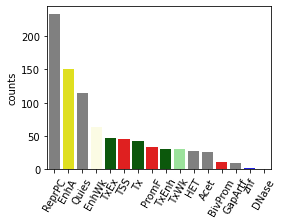

In [82]:
# Ploting the distribution of ALL Fine-mapped SNPs
fig, ax = plt.subplots(figsize=(4,3))

sns.barplot(x='major_state', y='counts', data=fm_state_cnts, hue='major_state', palette=state_colors, dodge=False)

ax.set_xlabel('');
ax.set_xticklabels(fm_state_cnts['major_state'], rotation = 60);

# ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(1.5, 0.9),
#           fancybox=True, shadow=False)
ax.legend_.set_visible(False)

chromhmm_summary_fn = os.path.join(outdir, 'sgl_pieqtl_snps_characterized_chromhmm.svg')
fig.savefig(chromhmm_summary_fn)

chromhmm_summary_fn = os.path.join(outdir, 'sgl_pieqtl_snps_characterized_chromhmm.png')
fig.savefig(chromhmm_summary_fn)

## Per study

In [83]:
intersect_df.gwas_source.value_counts()

T1D_34012112_Gaulton         945
T1D_32005708                 811
T1D_34594039_GCST90018925    386
Name: gwas_source, dtype: int64

In [84]:
intersect_df[['sid_y', 'geneid', 'cline']].drop_duplicates()

,sid_y,geneid,cline
0,6:31323409,ENSG00000206344,monocyte_naive
1,6:28324397,ENSG00000137185,NK-cell_naive
2,6:28324397,ENSG00000197062,B-cell_naive
3,6:28902133,ENSG00000204713,monocyte_naive
4,6:26573218,ENSG00000261353,CD4_T-cell_naive
...,...,...,...
2137,21:43845092,ENSG00000160183,CD4_T-cell_naive
2138,21:43845294,ENSG00000160183,CD8_T-cell_naive
2139,21:43845294,ENSG00000160183,CD4_T-cell_naive
2140,21:43846729,ENSG00000160183,CD8_T-cell_naive


## Loading the Extra Jurkat Loops

In [152]:
jurkat_loop_glob = '/mnt/BioAdHoc/Groups/vd-vijay/sourya/Projects/2020_IQTL_HiChIP/Data/' + \
                    'Jurkat_FitHiChIP_Loops/HiChIP_Samples_*/Out_FitHiChIP/' + \
                    'FitHiChIP_Peak2ALL_b5000_L10000_U3000000/P2PBckgr_1/Coverage_Bias/FitHiC_BiasCorr/' + \
                    'FitHiChIP.interactions_FitHiC_Q0.01.bed'
jurkat_loop_files = glob.glob(jurkat_loop_glob)
jurkat_loops = sgls.read_multiple_tables_to_df(jurkat_loop_files, header=0)

In [154]:
jurkat_loops.loc[:, 'loop_id'] = sgls.create_loop_id_col(jurkat_loops)

In [162]:
jurkat_coords = jurkat_loops[jurkat_loops.columns[0:6].tolist() + ['loop_id']]

In [164]:
jurkat_loops_pbt = pbt.BedTool.from_dataframe(jurkat_coords)

## Overlap SG pairs with Jurkat loops

In [147]:
# copy the intersect data
intersect_spg_df = intersect_df.copy()
intersect_spg_df.columns = sgls.add_prefix_to_names(intersect_spg_df.columns.tolist(), 'hits_')

# create a coordinates only dataframe 
snp_coords = sgls.snp2bed_df(intersect_spg_df[['hits_CHR', 'hits_POS']])
tss_coords = sgls.snp2bed_df(intersect_spg_df[['hits_CHR', 'hits_TSS']])

intersect_coords_df = pd.concat([snp_coords, tss_coords], axis=1)
intersect_coords_df.columns = ['snp_chr', 'snp_start', 'snp_end', 'gene_chr', 'gene_start', 'gene_end']
intersect_coords_df.columns = sgls.add_prefix_to_names(intersect_coords_df.columns.tolist(), 'hits_')
intersect_coords_df['hits_sgp_id'] = sgls.create_loop_id_col(intersect_coords_df)

# add sgp id to the full dataframe
intersect_spg_df.loc[:, 'hits_sgp_id'] = intersect_coords_df['hits_sgp_id'].tolist()

In [182]:
interset_wJurkat = sgls.pairtopair_dataframe(intersect_coords_df, jurkat_loops)

/mnt/bioadhoc-temp/Groups/vd-ay/jreyna/software/mamba/envs/hichip-db/lib/python3.9/site-packages/pybedtools/bedtool.py:3703: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 17 fields; you can supply custom names with the `names` kwarg
  warn(


Remaining steps:
- Add back meta from each
- Check out genes

In [183]:
interset_wJurkat

,hits_snp_chr,hits_snp_start,hits_snp_end,hits_gene_chr,hits_gene_start,hits_gene_end,hits_sgp_id,chr1,s1,e1,chr2,s2,e2,cc,Coverage1,isPeak1,Bias1,Mapp1,GCContent1,RESites1,Coverage2,isPeak2,Bias2,Mapp2,GCContent2,RESites2,Dist,p,exp_cc_Bias,p_Bias,dbinom_Bias,P-Value_Bias,Q-Value_Bias,file,loop_id
0,chr6,31323408,31323409,chr6,31165536,31165537,chr6.31323408.31323409.chr6.31165536.31165537,chr6,31165000.0,31170000.0,chr6,31320000.0,31325000.0,20.0,3889.0,1.0,10.191794,0.0,0.0,0.0,676.0,1.0,1.771574,0.0,0.0,0.0,155000.0,2.016853e-07,4.005737,2.342296e-07,8.469382e-09,1.044046e-08,7.887956e-05,/mnt/BioAdHoc/Groups/vd-vijay/sourya/Projects/...,chr6.31165000.31170000.chr6.31320000.31325000
1,chr6,31323408,31323409,chr6,31165536,31165537,chr6.31323408.31323409.chr6.31165536.31165537,chr6,31165000.0,31170000.0,chr6,31320000.0,31325000.0,20.0,3899.0,1.0,10.155251,0.0,0.0,0.0,657.0,1.0,1.711208,0.0,0.0,0.0,155000.0,2.021119e-07,3.996217,2.322386e-07,8.153010e-09,1.004497e-08,7.535110e-05,/mnt/BioAdHoc/Groups/vd-vijay/sourya/Projects/...,chr6.31165000.31170000.chr6.31320000.31325000
2,chr6,31323408,31323409,chr6,31165536,31165537,chr6.31323408.31323409.chr6.31165536.31165537,chr6,31165000.0,31170000.0,chr6,31320000.0,31325000.0,20.0,4238.0,1.0,10.283181,0.0,0.0,0.0,682.0,1.0,1.654820,0.0,0.0,0.0,155000.0,2.022006e-07,4.258893,2.285018e-07,2.239721e-08,2.801637e-08,1.718236e-04,/mnt/BioAdHoc/Groups/vd-vijay/sourya/Projects/...,chr6.31165000.31170000.chr6.31320000.31325000
3,chr6,31323408,31323409,chr6,31165536,31165537,chr6.31323408.31323409.chr6.31165536.31165537,chr6,31165000.0,31170000.0,chr6,31320000.0,31325000.0,26.0,4853.0,1.0,10.035934,0.0,0.0,0.0,814.0,1.0,1.683340,0.0,0.0,0.0,155000.0,2.026620e-07,4.974057,2.244380e-07,2.231770e-11,2.730960e-11,3.806092e-07,/mnt/BioAdHoc/Groups/vd-vijay/sourya/Projects/...,chr6.31165000.31170000.chr6.31320000.31325000
4,chr6,31323408,31323409,chr6,31165536,31165537,chr6.31323408.31323409.chr6.31165536.31165537,chr6,31165000.0,31170000.0,chr6,31320000.0,31325000.0,25.0,4826.0,1.0,10.043671,0.0,0.0,0.0,809.0,1.0,1.683657,0.0,0.0,0.0,155000.0,2.026249e-07,4.941546,2.244623e-07,1.022904e-10,1.260456e-10,1.449163e-06,/mnt/BioAdHoc/Groups/vd-vijay/sourya/Projects/...,chr6.31165000.31170000.chr6.31320000.31325000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3673,chr21,43845091,43845092,chr21,43816954,43816955,chr21.43845091.43845092.chr21.43816954.43816955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3674,chr21,43845293,43845294,chr21,43816954,43816955,chr21.43845293.43845294.chr21.43816954.43816955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3675,chr21,43845293,43845294,chr21,43816954,43816955,chr21.43845293.43845294.chr21.43816954.43816955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3676,chr21,43846728,43846729,chr21,43816954,43816955,chr21.43846728.43846729.chr21.43816954.43816955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
tdf = intersect_df.merge(interset_wJurkat,
                   left_on=['CHR', 'POS', 'TSS'], 
                   right_on=['hits_snp_chr', 'hits_snp_end', 'hits_gene_end'])

In [192]:
for g in tdf.Target_geneName.unique():
    print(g)

HCG27
ZSCAN9
RP5-874C20.3
TRIM27
CTA-14H9.5
BTN2A3P
TAP2
RPL32P1
WDR46
HCG4P7
BTNL2
C6orf10
ZNRD1-AS1
ZKSCAN4
BTN2A1
BTN2A2
XXbac-BPG181B23.7
LY6G5B
BTN3A1
TCF19
SUOX
MICA
CCHCR1
LY6G5C
IFITM4P
BTN3A2
XXbac-BPG299F13.14
XXbac-BPG299F13.17
HMGN4
LST1
PTPN22
TMEM116
HCG4P11
ZFP57
SKIV2L
DHX16
FLOT1
PPP1R18
ZNF165
Y_RNA
TRIM26
HCG18
MICB
PRRC2A
BAG6
CSNK2B
C6orf47
HCG4P3
HCG24
HCG23
ZDHHC20P1
GNL1
ZNF192P1
ZSCAN23
HECTD4
HCG4B
RNF39
PFDN6
BACH2
C1orf216
FHL3
SF3A3
RGS1
NPM1P33
KRT18P39
CD28
SLC22A5
VARS2
MRPS18B
TUBB
C6orf136
NCR3
C6orf48
AIF1
MSH5
PPT2
AP003774.1
M6PR
RP11-75L1.1
ATXN2
MAPKAPK5
CTSH
RP11-485G7.6
RMI2
DND1P1
KANSL1-AS1
RP11-973H7.1
ZGLP1
PRKD2
TMPRSS3
